# Theoretical bounds on radial velocity precision

This notebook demonstrates how to compute theoretical bounds on RV-precision given a synthetic spectrum and an LSF.  Korg has a few functions that make this easier, based on [Bouchy et al. 2001, A&A, 374, 733](https://ui.adsabs.harvard.edu/abs/2001A%26A...374..733B/abstract).

In [1]:
using Korg, PyPlot

Precompiling Korg
  ✓ Korg
  1 dependency successfully precompiled in 57 seconds. 122 already precompiled.


First, specify the wavelengths and LSF.  We'll use the APOGEE wavelength coverage and resolution.

In [2]:
synth_wls = 15_000:0.01:17_000

# the APOGEE wavelength grid
delLog = 6e-6; 
apowls = 10 .^range((start=4.179-125*delLog),step=delLog,length=8575+125)

LSF = Korg.compute_LSF_matrix(synth_wls, apowls, 22_500);
;

Constructing LSF matrix 100%|████████████████████████████| Time: 0:00:33


Synthesize a solar spectrum, rectify it, and convolve it with the LSF.

In [3]:
apolines = Korg.get_APOGEE_DR17_linelist(include_water=true);
A_X = format_A_X()
atm = Korg.interpolate_marcs(5777, 4.44, A_X)
sol = synthesize(atm, apolines, A_X, synth_wls);
rectified_flux = sol.flux ./ sol.cntm
flux = LSF * rectified_flux
;

Let's suppose that you observe a a star with this spectra at $S/N = 50$.

In [4]:
SNR = 50.0
obs_err = flux ./ SNR
;

## Exact calculation
This function provides the exact RV precision bound (in the small redshift limit) in m/s.

In [5]:
noise_prec = Korg.RV_prec_from_noise(rectified_flux, synth_wls, apowls, LSF, obs_err)

49.42231759086424

## $Q$-factor calculation
We can also calculate the $Q$-factor, which provides an approximately $S/N$-independent notion of the RV "information" in the spectrum.

In [6]:
Q = Korg.Qfactor(rectified_flux, synth_wls, apowls, LSF)

1221.9429829461203

We can calculate the appriximate RV precision bound from $Q$ with the code below.  Technically, the precision depends on the root-mean-squared per-pixel $S/N$ value, but for non-line-blanket spectra, this is approximately equal to the $S/N$. (Verifying this fact is left as an excercise to the reader.)

In [7]:
SNR_RMS = SNR # approximately
Npixels = length(apowls)
Q_prec = Korg.RV_prec_from_Q(Q, SNR, Npixels)  # this is a few m/s off of the exact calculation, but it's pretty close.

52.6065874688697

## $Q$ factor as a function of metallicity
Let's examine how the $Q$-factor changes as we change the metallicity for a star with solar $T_\mathrm{eff}$ and $\log g$. As we add more and deeper lines, there is more for an RV measurement to grab onto.

In [8]:
m_Hs = -5:1.0:0 #metallicity ([m/H]) values
Qs = map(m_Hs) do m_H
    A_X = format_A_X(m_H)
    atm = interpolate_marcs(5777, 4.44, A_X)
    sol = synthesize(atm, apolines, A_X, synth_wls);
    rectified_flux = sol.flux ./ sol.cntm
    flux = LSF * rectified_flux
    Korg.Qfactor(rectified_flux, synth_wls, apowls, LSF)
end
;

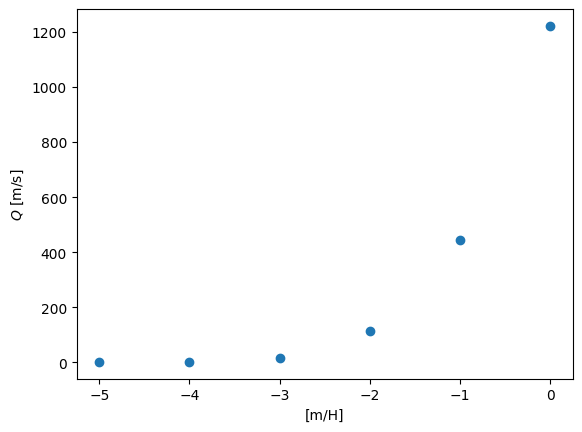

PyObject Text(26.28125, 0.5, '$Q$ [m/s]')

In [10]:
scatter(m_Hs, Qs)
xlabel("[m/H]")
ylabel(L"$Q$ [m/s]")

We can use the $Q$-factors to calculate the RV precision across $S/N$. Note that these precision estimates are not the whole story at high-$S/N$ where effects like granulation become important. 

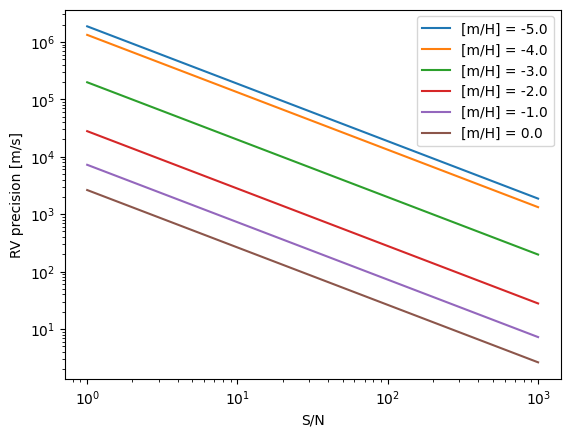

In [11]:
SNRs = 1:1:1000
for (m_H, Q) in zip(m_Hs, Qs)
    plot(SNRs, Korg.RV_prec_from_Q.(Q, SNRs, Npixels), label="[m/H] = $m_H")
end
legend()
ylabel("RV precision [m/s]")
xlabel("S/N")
yscale("log")
xscale("log")